In [1]:
%reload_ext watermark
%reload_ext autoreload
%autoreload 2
%watermark -v -p numpy,sklearn,pandas
%watermark -v -p cv2,PIL,matplotlib
%watermark -v -p torch,torchvision,torchaudio,pytorch_lightning
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.use_jedi = False


from IPython.display import display, HTML, Javascript
display(HTML('<style>.container { width:%d%% !important; }</style>' % 90))

def _IMPORT_(x):
    try:
        exec(x, globals())
    except:
        pass

CPython 3.6.9
IPython 7.16.1

numpy 1.19.4
sklearn 0.24.0
pandas 1.1.5
CPython 3.6.9
IPython 7.16.1

cv2 4.5.1
PIL 6.2.2
matplotlib 3.3.3
CPython 3.6.9
IPython 7.16.1

torch 1.8.0.dev20210103+cu101
torchvision 0.9.0.dev20210103+cu101
torchaudio not installed
pytorch_lightning 1.2.0


## Import Module

In [2]:
###
### Common ###
###

import os, io, time, math, base64
import subprocess

_IMPORT_('import numpy as np')
_IMPORT_('import pandas as pd')
_IMPORT_('from tqdm.notebook import tqdm')


In [3]:
###
### Torch ###
###
_IMPORT_('import torch')
_IMPORT_('import torch.nn as nn')
_IMPORT_('import torch.optim as O')
_IMPORT_('import torch.nn.functional as F')
_IMPORT_('from torchvision import models as M')
_IMPORT_('from torchvision import transforms as T')
_IMPORT_('from torch.utils.data import Dataset, DataLoader')

In [4]:
###
### Viz Model ###
###
_IMPORT_('import hiddenlayer as hl')
_IMPORT_('from graphviz import Digraph, Source')
_IMPORT_('from torchviz import make_dot')
_IMPORT_('from torchsummary import summary')

In [5]:
###
### Display ###
###
_IMPORT_('import cv2')
_IMPORT_('from PIL import Image')
_IMPORT_('import matplotlib.pyplot as plt')


def show_video(video_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    mp4 = open(video_path, 'rb').read()
    data_url = 'data:video/mp4;base64,' + base64.b64encode(mp4).decode()
    return HTML('<video %s %s controls src="%s" type="video/mp4"/>' % (W, H, data_url))

def show_image(image_path, width=None, height=None):
    W, H = '', ''
    if width:
        W = 'width=%d' % width
    if height:
        H = 'height=%d' % height
    img = open(image_path, 'rb').read()
    data_url = 'data:image/jpg;base64,' + base64.b64encode(img).decode()
    return HTML('<img %s %s src="%s"/>' % (W, H, data_url))

In [6]:
import os, io, time, math, base64
import numpy as np
import pandas as pd
import subprocess

## Install Depends Libraries

In [7]:
!apt install ffmpeg
!pip3 install youtube_dl

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.
You should consider upgrading via the '/usr/bin/python3.6 -m pip install --upgrade pip' command.


## Data Process

### Countix Dataset Download and Crop

```
    vs           cs                ce            ve
    |             |0.5           0.5|             |
    |-------|---------|---------|------|----------|
            |         |         |      |            
            ks       rs        re      ke
    
vs: the video start
ve: the video end
ks: the kinetics start
ke: the kinetics end
rs: repetition start
re: repetition end
cs: clip video start
ce: clip video end 

```

In [8]:
import youtube_dl

YOUTUBE_PREFIX = 'https://www.youtube.com/watch?v='
DATASET_PREFIX = '/data/datasets/cv/countix'

FRAME_WIDTH, FRAME_HEIGHT = 112, 112
NUM_FRAMES = 64
NUM_DMODEL = 512
REP_OUT_TIME_RATE = 0.12

SOCKS5_PROXY = 'socks5://127.0.0.1:1881'

YDL_OPTS = {
    'format': 'mp4',
    'proxy': SOCKS5_PROXY,
    'quiet': True,
    'max_filesize': 30000000, # 30MB
}

def video_download_crop(vid, fps, wh, ss, to, raw_dir, out_dir, force=False):
    raw_file = f'{raw_dir}/{vid}.mp4'
    out_file = '%s/%s_%010.6f_%010.6f.mp4' % (out_dir, vid, ss, to)

    if os.path.exists(out_file):
        if force:
            os.remove(out_file)
        return out_file

    if not os.path.exists(raw_file):
        YDL_OPTS['outtmpl'] = raw_file
        with youtube_dl.YoutubeDL(YDL_OPTS) as ydl:
            ydl.download([f'{YOUTUBE_PREFIX}{vid}'])

    if os.path.exists(raw_file):
        cmd = 'ffmpeg -i %s -v 0 -r %f -s %s -ss %s -to %s -an %s' % (
                raw_file, fps, wh, ss, to, out_file)
        subprocess.call(cmd, shell=True)
        return out_file

    return None

def data_preprocess(data_prefix, phase, force=False):
    df = pd.read_csv(f'{data_prefix}/countix_{phase}.csv')
    raw_dir = f'{data_prefix}/raw/{phase}'
    out_dir = f'{data_prefix}/{phase}'
    os.makedirs(raw_dir, exist_ok=True)
    os.makedirs(out_dir, exist_ok=True)
    df['file_name'] = None
    df['rep_start_frame'] = 0
    df['rep_end_frame'] = 0
    for idx, row in df.iterrows():
        if phase == 'test' or phase == 'sample':
            vid, ks, ke, rs, re, count, file_name, rsf, rse = row
        else:
            vid, _, ks, ke, rs, re, count, file_name, rsf, rse = row

        interval = re - rs
        cs = float(max([ks, rs - REP_OUT_TIME_RATE * interval]))
        ce = float(min([ke, re + REP_OUT_TIME_RATE * interval]))
        try:
            fps = NUM_FRAMES / (ce - cs)
            out_file = video_download_crop(vid, 
                    fps, '%dx%d' % (FRAME_WIDTH, FRAME_HEIGHT), cs, ce, raw_dir, out_dir, force)
            if out_file is not None:
                cap = cv2.VideoCapture(out_file)
                cnt = cap.get(cv2.CAP_PROP_FRAME_COUNT)
                if cnt >= NUM_FRAMES:
                    print('preprocess file: %s' % out_file)
                    df.loc[idx, 'rep_start_frame'] = int(fps * (rs - cs))
                    df.loc[idx, 'rep_end_frame'] = int(fps * (re - cs))
                    df.loc[idx, 'file_name'] = os.path.basename(out_file)
                else:
                    print(f'frames is less than {NUM_FRAMES}')     
            else:
                print('download or crop [%s] fail' % vid)
        except Exception as err:
            print('%s' % err)
    sub_df = df[df['file_name'].notnull()]
    sub_df.to_csv(f'{data_prefix}/sub_countix_{phase}.csv', index=False, header=True)
    return sub_df

# data_preprocess(DATASET_PREFIX, 'test')
# data_preprocess(DATASET_PREFIX, 'val')
# data_preprocess(DATASET_PREFIX, 'train')

In [9]:
!ls $DATASET_PREFIX

README		    countix_val.csv	  sub_countix_train.csv  val
countix_sample.csv  raw			  sub_countix_val.csv
countix_test.csv    repnet.pt		  test
countix_train.csv   sub_countix_test.csv  train


### Countix Dataset Sample Display

In [10]:
df_train = pd.read_csv(f'{DATASET_PREFIX}/sub_countix_train.csv')

In [11]:
df_train.head()

,video_id,class,kinetics_start,kinetics_end,repetition_start,repetition_end,count,file_name,rep_start_frame,rep_end_frame
0,APkos_Kqa3M,battle rope training,17,27,17.000000,26.976643,20,APkos_Kqa3M_017.000000_027.000000.mp4,0,63
1,AaTvErday_s,battle rope training,121,131,121.900000,131.000000,12,AaTvErday_s_121.000000_131.000000.mp4,5,64
2,AnEm66_ZHvQ,battle rope training,20,30,21.001001,29.809810,8,AnEm66_ZHvQ_020.000000_030.000000.mp4,6,62
3,AsJgDPLu_ro,battle rope training,13,23,13.000000,14.468135,3,AsJgDPLu_ro_013.000000_014.644311.mp4,0,57
4,AsJgDPLu_ro,battle rope training,13,23,18.638972,22.876543,11,AsJgDPLu_ro_018.130463_023.000000.mp4,6,62


In [12]:
sample_video_item = df_train.iloc[0]
sample_video_path = f'{DATASET_PREFIX}/train/{sample_video_item.file_name}'
show_video(sample_video_path, width=600)

### Countix Dataset Loader 

In [13]:
class CountixDataset(Dataset):
    
    def __init__(self, data_root, phase, frame_size=112, num_frames=64):
        self.data_root = data_root
        self.phase = phase
        self.num_frames = num_frames
        self.frame_size = (frame_size, frame_size) if isinstance(frame_size, int) else frame_size
        self.df = pd.read_csv(f'{data_root}/sub_countix_{phase}.csv')

    def __getitem__(self, index):
        item = self.df.iloc[index]
        start = item.rep_start_frame
        end = item.rep_end_frame
        count = self.df.loc[index, 'count']
        
        path = f'{self.data_root}/{self.phase}/{item.file_name}'
        
        frames = []
        cap = cv2.VideoCapture(path)
        while cap.isOpened():
            ret, frame = cap.read()
            if ret is False:
                break
            img = Image.fromarray(frame)
            trans = T.Compose([
                T.Resize(self.frame_size),
                T.ToTensor(),       
                T.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])])
            frames.append(trans(img).unsqueeze(0))
        cap.release()
        
        X = frames[:self.num_frames]
        X = torch.cat(X)

        period_length = (end - start) / count
        y1 = np.full((self.num_frames, 1), fill_value=period_length)
        y2 = np.ones((self.num_frames, 1)) 
        for i in range(self.num_frames):
            if i < start or i > end:
                y1[i] = 0
                y2[i] = 0
                
        # y1 = torch.LongTensor(y1)
        y1 = torch.FloatTensor(y1)
        y2 = torch.FloatTensor(y2)
        y3 = torch.FloatTensor([count])
        return X, y1, y2, y3

    def __len__(self):
        return len(self.df)

In [14]:
train_dataset = CountixDataset(DATASET_PREFIX, 'train')
train_loader = DataLoader(train_dataset, batch_size=4, num_workers=4)

In [15]:
X, y1, y2, y3 = next(iter(train_loader))
X.shape, y1.shape, y2.shape, y3

(torch.Size([4, 64, 3, 112, 112]),
 torch.Size([4, 64, 1]),
 torch.Size([4, 64, 1]),
 tensor([[20.],
         [12.],
         [ 8.],
         [ 3.]]))

## RepNet Model


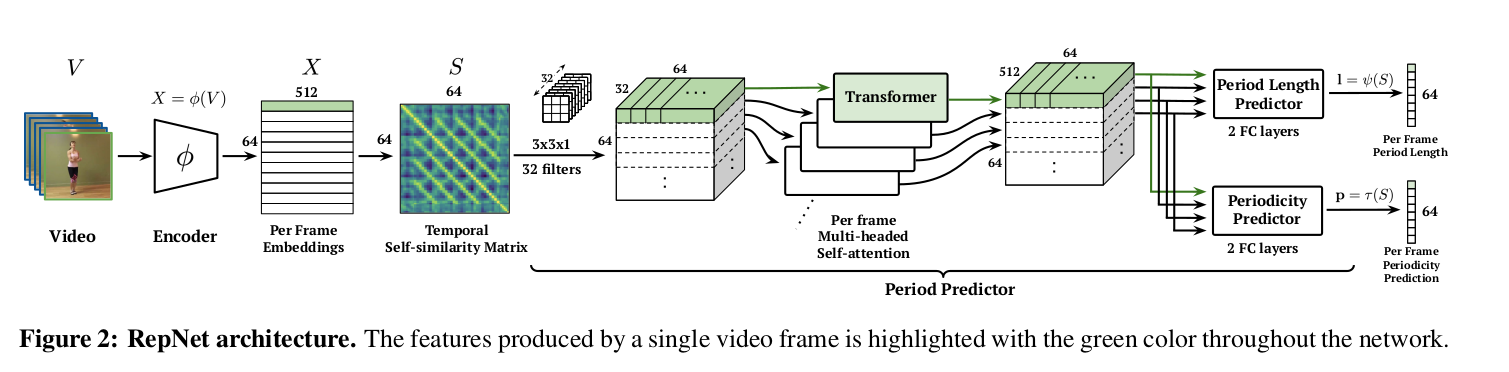

In [16]:
show_image('repnet_model.png', width=1000)

### Encoder

#### Convolutional Feature Extractor

In [17]:
class ResNet50Base5D(nn.Module):
    def __init__(self, pretrained=False, m=2):
        super().__init__()
        base_model = M.resnet50(pretrained=pretrained)
        
        if m == 1:
            # method-1:
            base_model.fc = nn.Identity()
            base_model.avgpool = nn.Identity()
            base_model.layer4 = nn.Identity()
            base_model.layer3[3] = nn.Identity()
            base_model.layer3[4] = nn.Identity()
            base_model.layer3[5] = nn.Identity()
            self.base_model = base_model
        else:
            # method-2:
            self.base_model = nn.Sequential(
                *list(base_model.children())[:-4],
                *list(base_model.children())[-4][:3])
 
    def forward(self, x):
        N, S, C, H, W = x.shape 
        x = x.view(-1, C, H, W) # 5D -> 4D
        x = self.base_model(x)
        x = x.view(N, S, x.shape[1], x.shape[2], x.shape[3]) # 4D -> 5D
        return x

In [18]:
resnet50 = ResNet50Base5D(pretrained=True, m=2)
resnet50

ResNet50Base5D(
  (base_model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): C

In [19]:
resnet50_outputs = resnet50(X)
resnet50_outputs.shape

torch.Size([4, 64, 1024, 7, 7])

#### Temporal Context

In [20]:
class TemporalContext(nn.Module):
    def __init__(self, in_channels=1024, out_channels=512):
        super().__init__()
        self.conv3D = nn.Sequential(
            nn.Conv3d(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 3,
                padding = 3,
                dilation = 3),
            nn.BatchNorm3d(out_channels),
            nn.ReLU())
        
    def forward(self, x):
        # (N, S, C, H, W) -> (N, C, S, H, W)
        x = x.transpose(1, 2)
        x = self.conv3D(x)
        return x

In [21]:
TC = TemporalContext()
TC

TemporalContext(
  (conv3D): Sequential(
    (0): Conv3d(1024, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(3, 3, 3), dilation=(3, 3, 3))
    (1): BatchNorm3d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [22]:
tc_outputs = TC(resnet50_outputs)
tc_outputs.shape

torch.Size([4, 512, 64, 7, 7])

#### Dimensionality Reduction

In [23]:
class GlobalMaxPool(nn.Module):
    def __init__(self, m=2):
        super().__init__()
        self.m = m
        
        # method:2
        self.pool = nn.MaxPool3d(kernel_size = (1, 7, 7))
        
    def forward(self, x):
        # Inputs: (N, C, S, 7, 7)
        # method:1
        if self.m == 1:
            x, _ = torch.max(x, dim=4)
            x, _ = torch.max(x, dim=3)
        else:
            # method:2
            x = self.pool(x).squeeze(-1).squeeze(-1)
        
        x = x.transpose(1, 2)
        return x # (N, S, C)

In [24]:
GMP = GlobalMaxPool(m=2)
gmp_outputs = GMP(tc_outputs)
gmp_outputs.shape

torch.Size([4, 64, 512])

### Temporal Self-similarity Matrix(TSM)

In [25]:
class TemproalSelfMatrix(nn.Module):
    def __init__(self, temperature=13.544, device='cpu', m=2):
        super().__init__()
        self.temperature = temperature
        self.device = device
        self.m = m
        
    def calc_sims(self, x):
        # (N, S, E)  --> (N, 1, S, S)
        S = x.shape[1]
        
        I = torch.ones(S).to(self.device)
        xr = torch.einsum('nse,h->nhse', (x, I))
        xc = torch.einsum('nse,h->nshe', (x, I))
        diff = xr - xc
        return torch.einsum('nsge,nsge->nsg', (diff, diff))
        
    def pairwise_l2_distance(self, x):
        # (S, E)
        a, b = x, x
        norm_a = torch.sum(torch.square(a), dim=1)
        norm_a = torch.reshape(norm_a, [-1, 1])
        norm_b = torch.sum(torch.square(b), dim=1)
        norm_b = torch.reshape(norm_b, [1, -1])
        b = torch.transpose(b, 0, 1)  # a: 64x512  b: 512x64
        zero_tensor = torch.zeros(64, 64)
        dist = torch.maximum(norm_a - 2.0 * torch.matmul(a, b) + norm_b, torch.tensor(0.0).to(self.device))
        return dist
        
    def forward(self, x):
        # x: (N, S, E)
        # method: 1
        if self.m == 1:
            # x = torch.transpose(x, 1, 2)
            sims_list = []
            for i in range(x.shape[0]):
                sims_list.append(self.pairwise_l2_distance(x[i]))
            sims = torch.stack(sims_list)
        else:
            # method: 2
            sims = self.calc_sims(x)
        
        sims = sims.unsqueeze(1)
        sims = F.softmax(-sims/self.temperature, dim=-1)
        return F.relu(sims) # (N, 1, S, S)

In [26]:
TSM = TemproalSelfMatrix(m=2)
tsm_outputs = TSM(gmp_outputs)
tsm_outputs.shape

torch.Size([4, 1, 64, 64])

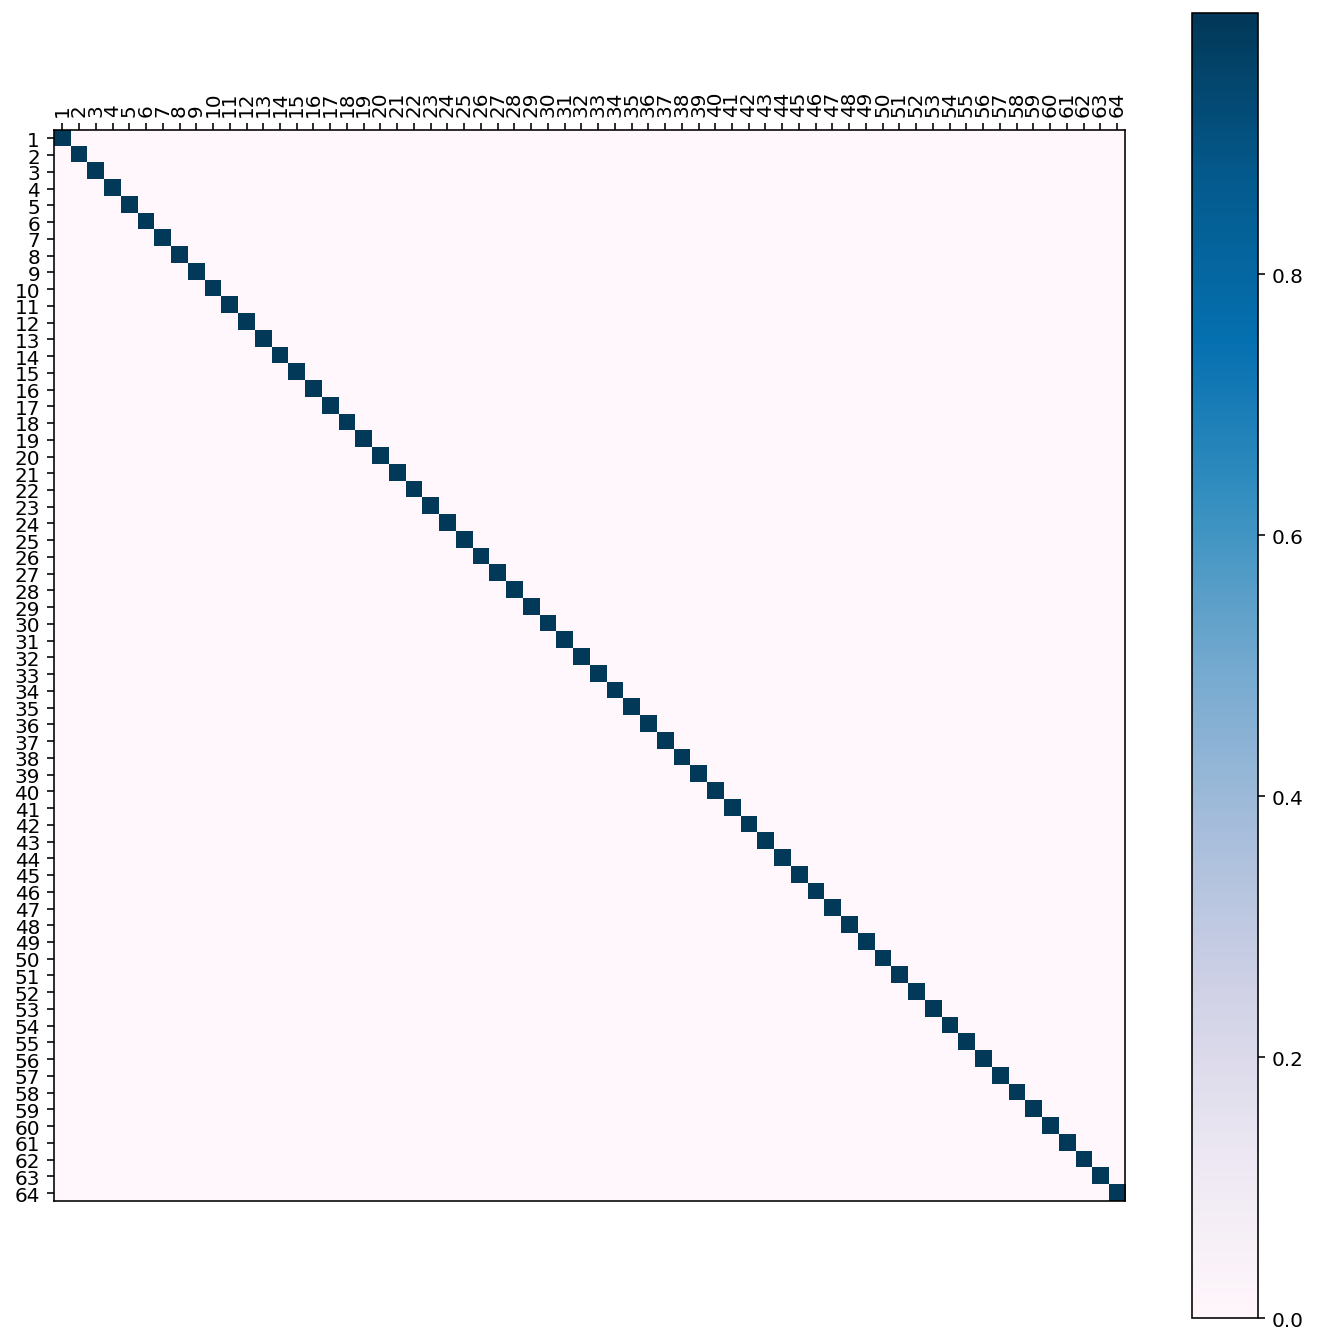

In [27]:
def show_hotmap(data):
    fig = plt.figure(figsize=(12, 12))
    
    xlabel = range(1, data.shape[0] + 1)
    ylabel = range(1, data.shape[0] + 1)
    ax = fig.add_subplot(111)
    
    ax.set_xticks(range(len(xlabel)))
    ax.set_xticklabels(xlabel, rotation=90)
    ax.xaxis.set_ticks_position('top') 
    
    ax.set_yticks(range(len(ylabel)))
    ax.set_yticklabels(ylabel)
    
    im = ax.imshow(data, cmap=plt.cm.PuBu)
    plt.colorbar(im)
tsm_hotmap_data = tsm_outputs[0][0].detach().numpy()
show_hotmap(tsm_hotmap_data)

### Period Predictor

#### Features Projection

In [28]:
class FeaturesProjection(nn.Module):
    def __init__(self, num_frames=64, out_features=512, dropout=0.2):
        super().__init__()
        self.num_frames = num_frames
        self.out_features = out_features
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=32,
                      kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(p=dropout))
        self.projection = nn.Sequential(
            nn.Linear(num_frames*32, out_features),
            nn.ReLU(),
            nn.LayerNorm(out_features))

    def forward(self, x):
        x = self.features(x) # N, 32, S, S
        x = x.permute(0, 2, 3, 1)
        x = x.reshape(x.size(0), self.num_frames, -1) # N, S, 32*S
        x = self.projection(x) # N, S, 512
        return x

In [29]:
FPL = FeaturesProjection()
fpl_outputs = FPL(tsm_outputs)
fpl_outputs.shape

torch.Size([4, 64, 512])

#### Transformer Encoder

In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, device='cpu'):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False 
        position = torch.arange(0, max_len, dtype=torch.float, device=device).unsqueeze(1)
        _2i = torch.arange(0, d_model, step=2, dtype=torch.float, device=device)
        div_term = torch.exp(_2i * (-math.log(10000.0) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0).transpose(0, 1)

    def forward(self, x):
        # (S, N, 512)
        x = x + self.encoding[:x.size(0), :]
        return self.dropout(x)
    
class TransEncoder(nn.Module):
    def __init__(self, num_frames=64, d_model=512, 
                 n_head=4, dim_ff=512, dropout=0.2,
                 num_layers=2, device='cpu'):
        super(TransEncoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_head,
            dim_feedforward=dim_ff,
            dropout=dropout,
            activation='relu')
        encoder_norm = nn.LayerNorm(d_model)
        
        self.trans_encoder = nn.Sequential(
            PositionalEncoding(d_model, 0.25, num_frames, device),
            nn.TransformerEncoder(encoder_layer, num_layers, encoder_norm))
                
    def forward(self, x):
        x = x.transpose(0, 1)
        x = self.trans_encoder(x)
        x = x.transpose(0, 1)
        return x

In [31]:
TE = TransEncoder(NUM_FRAMES, d_model=NUM_DMODEL, n_head=4, dropout=0.2, dim_ff=512)
te_outputs = TE(fpl_outputs)
te_outputs.shape

torch.Size([4, 64, 512])

#### Period Classifier

In [32]:
class PeriodClassifier(nn.Module):
    def __init__(self, num_frames=64, in_features=512):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=512),
            nn.LayerNorm(512),
            nn.Linear(in_features=512, out_features=num_frames//2),
            nn.Linear(in_features=num_frames//2, out_features=1))
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [33]:
pc = PeriodClassifier(NUM_FRAMES)
pc_outputs = pc(te_outputs)
pc_outputs.shape

torch.Size([4, 64, 1])

### Make All Together

In [34]:
class RepNet(nn.Module):
    def __init__(self, num_frames=64, num_dmodel=512, device='cpu'):
        super().__init__()
        ## Encoder
        self.resnet50 = ResNet50Base5D(pretrained=True)
        self.tcxt = TemporalContext()
        self.maxpool = GlobalMaxPool()
        ## TSM
        self.tsm = TemproalSelfMatrix(temperature=13.544, device=device)
        ## Period Predictor
        self.projection = FeaturesProjection(num_frames=num_frames, out_features=num_dmodel)
        ### period length prediction
        self.trans1 = TransEncoder(num_frames, d_model=num_dmodel, n_head=4,
                                   dropout=0.2, dim_ff=num_dmodel, device=device)
        self.pc1 = PeriodClassifier(num_frames, num_dmodel)
        ### periodicity prediction
        self.trans2 = TransEncoder(num_frames, d_model=num_dmodel, n_head=4,
                                   dropout=0.2, dim_ff=num_dmodel, device=device)
        self.pc2 = PeriodClassifier(num_frames, num_dmodel)
        
    def forward(self, x):
        x = self.resnet50(x)
        x = self.tcxt(x)
        x = self.maxpool(x)
        x = self.tsm(x)
        x = self.projection(x)
        
        y1 = self.pc1(self.trans1(x))
        y2 = self.pc2(self.trans2(x))
        return y1, y2

In [35]:
repnet = RepNet()
y1, y2 = repnet(X)
y1.shape, y2.shape

(torch.Size([4, 64, 1]), torch.Size([4, 64, 1]))

## Train

In [36]:
num_epochs = 30
lr = 0.01
device = torch.device("cuda")

train_dataset = CountixDataset(DATASET_PREFIX, 'train')
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=4)

model = RepNet(NUM_FRAMES, NUM_DMODEL, device)

In [37]:
optimizer = O.Adam(model.parameters(), lr=lr)
scheduler = O.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)
loss_mae = nn.SmoothL1Loss()
# loss_mse = nn.MSELoss()
loss_bce = nn.BCEWithLogitsLoss()

In [38]:
ckpt_path = f'{DATASET_PREFIX}/repnet.pt'
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'], strict = True)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

model = model.to(device)

In [ ]:
torch.cuda.empty_cache()
for epoch in tqdm(range(0, num_epochs)):
    pbar = tqdm(train_loader, total=len(train_loader))
    period_length_loss = []
    period_count_loss = []
    train_loss = []
    curr_lr = scheduler.get_last_lr()
    for i, (X, y1, y2, y3) in enumerate(pbar):
        X = X.to(device)
        y1, y2, y3 = y1.to(device), y2.to(device), y3.to(device)
        
        y1_pred, y2_pred = model(X)
        y3_pred = torch.sum((y2_pred > 0) / (y1_pred + 1e-1), 1)
        
        loss1 = loss_mae(y1_pred, y1)
        loss2 = loss_bce(y2_pred, y2)
        loss3 = loss_mae(y3_pred, y3)
        loss = loss1 + 5*loss2 + loss3
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        period_length_loss.append(loss1.item())
        period_count_loss.append(loss3.item())
        train_loss.append(loss.item())
        pbar.set_postfix({
            'Epoch': epoch,
            'Learning Rate': curr_lr,
            'P Length Loss': np.mean(period_length_loss),
            'P Count Loss': np.mean(period_count_loss),
            'Train Loss': np.mean(train_loss)
        })
    scheduler.step()
    
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, ckpt_path)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

## References

1. https://arxiv.org/pdf/2006.15418.pdf

2. https://colab.research.google.com/github/google-research/google-research/blob/master/repnet/repnet_colab.ipynb#scrollTo=76L5XFonl_Bw